In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

Common_Literacy_AVGW2V_POS.ipynb
CommonLiteracyBertModels.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D_SVD.ipynb
Common_Literacy_BOW_TFIDF_AVGW2V300D.ipynb
CommonLiteracy_CNN_Model.ipynb
Dataset


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from mlxtend.regressor import StackingRegressor

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [ ]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [ ]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [ ]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

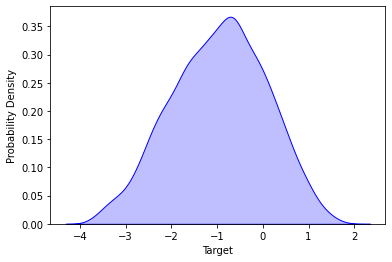

In [ ]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [ ]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

### Pretrained Glove Vector assignment

In [ ]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

--2021-07-06 13:10:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-06 13:10:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-06 13:10:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [ ]:
#unzip the downloaded glove vectors to drive
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       y

replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.300d.txt       y



In [ ]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

d_model = 100
glove_dict = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_dict))

# checking the dictionary word shape
print(glove_dict['the'].shape)

Indexing word vectors.
Found 400000 word vectors.
(100,)


In [ ]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_dict.keys())

In [ ]:
# # code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_50d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

### Cleaning the text data for any special characters and numerical characters

In [ ]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(r'\w*\d\w*', '', phrase).strip()
    return phrase

In [ ]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 1838.81it/s]


In [ ]:
print(df_train['excerpt'].values[0])
print("="*100)
print(df_train['cleaned_excerpt'].values[0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.
young p

In [ ]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [ ]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(d_model) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_dict[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Glove Average Word 2 Vec With Positional Encoding

In [ ]:
def positionalEncoding2d(max_sentence_length,d_model):
  positional_embeddings = np.zeros((max_sentence_length, d_model))
  for position in range(max_sentence_length):
      for i in range(0, d_model, 2):
        positional_embeddings[position, i] = (np.sin(position/(10000 ** ((2*i) / d_model))))
        positional_embeddings[position, i + 1] = (np.cos(position/(10000 ** ((2*(i+1)) / d_model))))
  return positional_embeddings

def Avg_W2V_Pos(selfie): # give a pandas series into
  array_col_size = selfie.size
  AvgW2V_list = []; 
  for sentence in tqdm(selfie.values): 
      sentence = sentence.split()
      max_sentence_length = len(sentence)
      empty_vector = np.empty((0,d_model),dtype=float)
      posEmbed = positionalEncoding2d(max_sentence_length,d_model)
      for word in sentence:
          if word in glove_words: 
              vector = glove_dict[word] 
              vectorTranspose = np.reshape(vector,(-1,d_model))
              empty_vector = np.append(empty_vector,vectorTranspose,axis=0)
          else:
            vectorZeros = np.zeros((1,d_model),dtype=float)
            empty_vector = np.append(empty_vector,vectorZeros,axis=0)
      WordEmbedPOS = np.add(posEmbed, empty_vector)
      WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
      WordEmbedPOSColSum /= max_sentence_length
      AvgW2V_list.append(WordEmbedPOSColSum)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Splitting data into Train and cross validation(or test): Stratified Sampling

In [ ]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [ ]:
print(X_train.head(5))

2317    light canoe bark containing single human figur...
987     probably widely accepted theory explaining evo...
1367    illustrious sir honor hand royal highness lett...
1654    come paper process effective enlargements made...
2562    upon time queen ugliest little baby imaginable...
Name: cleaned_excerpt, dtype: object


### TF-IDF processing of text

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_tfidf = vectorizer.transform(X_train)
X_test_excerpt_tfidf = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf.shape, Y_train.shape)
print(X_test_excerpt_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 4870) (1898,)
(936, 4870) (936,)


### Bag of Words 

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_bow = vectorizer.transform(X_train)
X_test_excerpt_bow = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_bow.shape, Y_train.shape)
print(X_test_excerpt_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 4870) (1898,)
(936, 4870) (936,)


### Average Word 2 Vec

In [ ]:
X_train_excerpt_avg_w2v = Avg_W2V(X_train)
X_test_excerpt_avg_w2v = Avg_W2V(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:00<00:00, 5020.04it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


### Average Word 2 Vec with Positional Embedding

In [ ]:
X_train_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_train)
X_test_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v_pos.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v_pos.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:12<00:00, 73.45it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


## Truncated SVD Implementation

### Truncated SVD for TF-IDF

In [ ]:
# # Program to find the optimal number of components for Truncated SVD
# n_comp = [500,700,800,900,1000,1500,2000,2500,3000,3500,4000] # list containing different values of components
# explained = [] # explained variance ratio for each component of Truncated SVD
# for x in n_comp:
#     svd = TruncatedSVD(n_components=x,n_iter=20)
#     svd.fit(X_train_excerpt_tfidf)
#     explained.append(svd.explained_variance_ratio_.sum())
#     print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
# plt.plot(n_comp, explained)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [ ]:
# best_SVD_tfidf = TruncatedSVD(n_components=2000,n_iter=20)
# best_SVD_tfidf.fit(X_train_excerpt_tfidf)

# X_train_excerpt_tfidf_svd = best_SVD_tfidf.transform(X_train_excerpt_tfidf)
# X_test_excerpt_tfidf_svd = best_SVD_tfidf.transform(X_test_excerpt_tfidf)

### Truncated SVD for Avg Word2Vec

In [ ]:
# # Program to find the optimal number of components for Truncated SVD
# n_comp = [4,10,15,20,30,40,50,60,70,80,90,95,100,150,200,250,299] # list containing different values of components
# explained = [] # explained variance ratio for each component of Truncated SVD
# for x in n_comp:
#     svd = TruncatedSVD(n_components=x)
#     svd.fit(X_train_excerpt_avgw2v)
#     explained.append(svd.explained_variance_ratio_.sum())
#     print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
# plt.plot(n_comp, explained)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [ ]:
# best_SVD_w2v = TruncatedSVD(n_components=150,n_iter=20)
# best_SVD_w2v.fit(X_train_excerpt_avgw2v)

# X_train_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_train_excerpt_avgw2v)
# X_test_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_test_excerpt_avgw2v)

# Various Models

### Linear Regression

In [ ]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_tfidf, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_tfidf,Y_train)

Y_pred = lr.predict(X_test_excerpt_tfidf)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.23402508 0.2027025  0.1503817  0.28200338 0.32088576] 0.23799968311660544 0.059573531816982876
This is root mean square error:  0.9320873223910385


In [ ]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_bow, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_bow,Y_train)

Y_pred = lr.predict(X_test_excerpt_bow)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[ 0.05933653  0.01023396 -0.01946265  0.14945605  0.1869945 ] 0.0773116766440709 0.07927537855735585
This is root mean square error:  0.9972720149852444


In [ ]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"Avg Word2Vec Pos":(X_train_excerpt_avg_w2v_pos,X_test_excerpt_avg_w2v_pos)}

### Function to run all models together

In [ ]:
def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1968s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0379s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.0s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.659545693401956
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6811531353742765


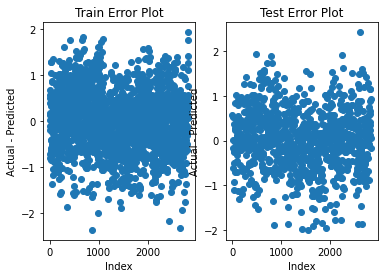

100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


In [ ]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0300s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0501s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6524260729215796
Root Mean squared Error Test for Avg Word2Vec Pos:  0.679802301484577


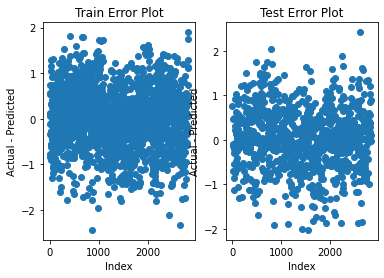

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


In [ ]:
ridge_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1.0]}
ridge = Ridge()

modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0855s.) Setting batch_size=2.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1873s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6828893987986665
Root Mean squared Error Test for Avg Word2Vec Pos:  0.698937019132654


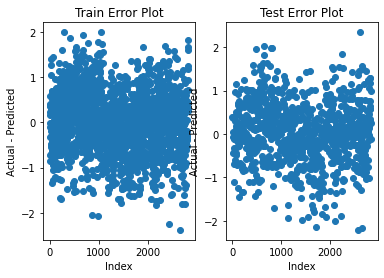

100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


In [ ]:
SGD_params = {'alpha':[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.3s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6985911153964792
Root Mean squared Error Test for Avg Word2Vec Pos:  0.7555248992164283


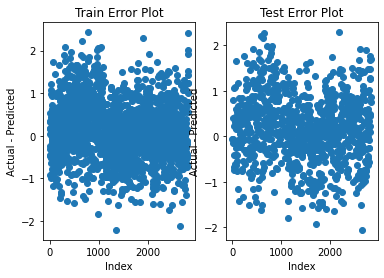

100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


In [ ]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Batch computation too slow (2.5076s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.6s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6595886306106645
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6888186454916354


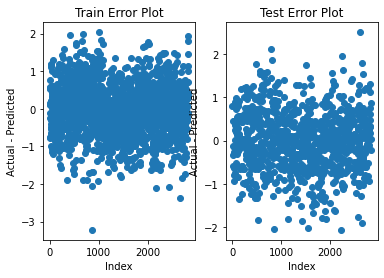

100%|██████████| 1/1 [00:28<00:00, 28.61s/it]


In [ ]:
SVR_params = {'C':range(0,30,5)}
LinearSVR = SVR(kernel='linear')

modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.48879577309783184
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6405956992038653


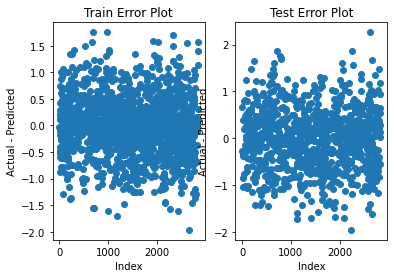

100%|██████████| 1/1 [01:16<00:00, 76.60s/it]


In [ ]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
RBF_SVR = SVR(kernel='rbf',gamma="scale")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Poly SVR

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.3s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=500, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.5770815516770362
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6517147544897354


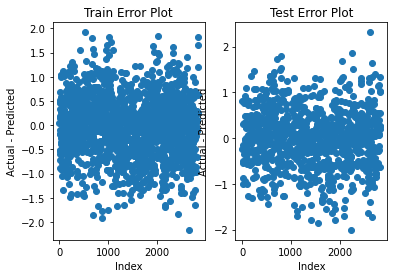

100%|██████████| 1/1 [00:22<00:00, 22.93s/it]


In [ ]:
SVR_params = {'C':[500,600,700,900,1000,1500,2000,3000,4000]}
Poly_SVR = SVR(kernel='poly',degree=5,gamma="auto")

modelfunction(Poly_SVR,data,Y_train,Y_test,SVR_params)

### Sigmoid SVR

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.8s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6792487482348704
Root Mean squared Error Test for Avg Word2Vec Pos:  0.704298518615182


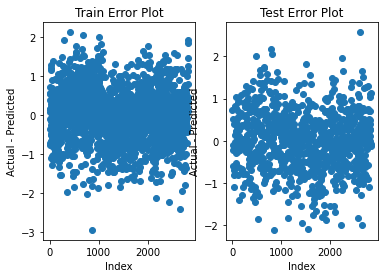

100%|██████████| 1/1 [00:26<00:00, 26.59s/it]


In [ ]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
Sig_SVR = SVR(kernel='sigmoid',gamma="auto")

modelfunction(Sig_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.9min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.26762211234901073
Root Mean squared Error Test for Avg Word2Vec Pos:  0.7018912572979543


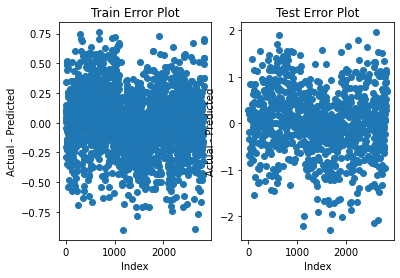

100%|██████████| 1/1 [02:01<00:00, 121.62s/it]


In [ ]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
modelfunction(RandomForest,data,Y_train,Y_test,RF_params)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   54.3s finished


[13:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.3987213863555667
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6678691849904611


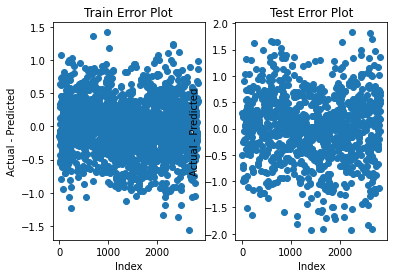

100%|██████████| 1/1 [00:56<00:00, 56.88s/it]


In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
modelfunction(xgb,data,Y_train,Y_test,xgb_params)

### Light GBM


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=140, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.2239896116515526
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6648385507127644


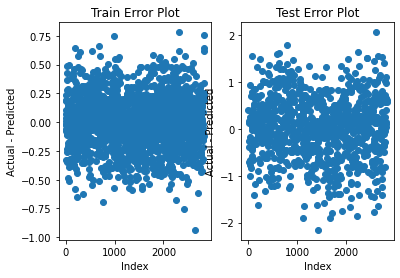


100%|██████████| 1/1 [04:58<00:00, 298.32s/it]


In [ ]:
from lightgbm import LGBMRegressor

LGBM_params = {'boosting_type':['gbdt','dart','goss'],'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

lgbm = LGBMRegressor()
modelfunction(lgbm,data,Y_train,Y_test,LGBM_params)

### CAT Boost


  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


0:	learn: 0.9906948	total: 88.3ms	remaining: 15.8s
1:	learn: 0.9610436	total: 115ms	remaining: 10.2s
2:	learn: 0.9328081	total: 141ms	remaining: 8.32s
3:	learn: 0.9093970	total: 168ms	remaining: 7.37s
4:	learn: 0.8892383	total: 194ms	remaining: 6.79s
5:	learn: 0.8703326	total: 220ms	remaining: 6.38s
6:	learn: 0.8513913	total: 246ms	remaining: 6.07s
7:	learn: 0.8355926	total: 272ms	remaining: 5.84s
8:	learn: 0.8193418	total: 300ms	remaining: 5.7s
9:	learn: 0.8048756	total: 326ms	remaining: 5.55s
10:	learn: 0.7936020	total: 354ms	remaining: 5.43s
11:	learn: 0.7825851	total: 381ms	remaining: 5.33s
12:	learn: 0.7719118	total: 410ms	remaining: 5.26s
13:	learn: 0.7598207	total: 436ms	remaining: 5.17s
14:	learn: 0.7492959	total: 462ms	remaining: 5.08s
15:	learn: 0.7384642	total: 486ms	remaining: 4.99s
16:	learn: 0.7307508	total: 515ms	remaining: 4.94s
17:	learn: 0.7216351	total: 541ms	remaining: 4.87s
18:	learn: 0.7147445	total: 569ms	remaining: 4.82s
19:	learn: 0.7079240	total: 598ms	remaini

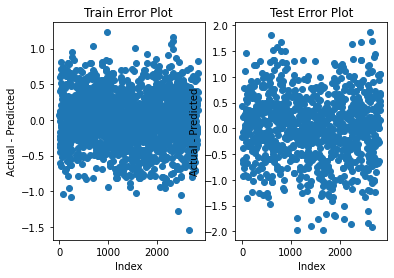


100%|██████████| 1/1 [03:38<00:00, 218.31s/it]


In [ ]:
# !pip install catboost
from catboost import CatBoostRegressor

CATBoost_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

CB = CatBoostRegressor()
modelfunction(CB,data,Y_train,Y_test,CATBoost_params)

### Histogram Gradient Boosting Regressor


  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.05,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=180, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.17003061445923942
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6579839732118172


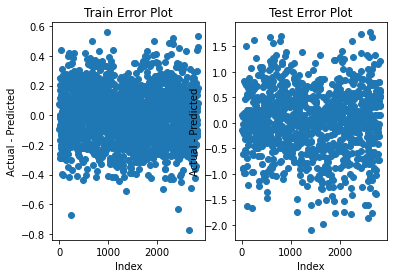


100%|██████████| 1/1 [02:07<00:00, 127.99s/it]


In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

HistBoost_params = {'max_iter': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

HB = HistGradientBoostingRegressor()
modelfunction(HB,data,Y_train,Y_test,HistBoost_params)

### Combining all the Predicted Values into a Data Frame

In [ ]:
# # Saving the prediction value to a dataframe
# prediction_train = pd.DataFrame(Y_pred_train_Lasso, columns = ['Lasso'])
# prediction_test = pd.DataFrame(Y_pred_test_Lasso, columns = ['Lasso'])

# prediction_train['Ridge'] = Y_pred_train_Ridge
# prediction_test['Ridge'] = Y_pred_test_Ridge
# prediction_train['SGD'] = Y_pred_train_SGD
# prediction_test['SGD'] = Y_pred_test_SGD
# prediction_train['KNN'] = Y_pred_train_KNN
# prediction_test['KNN'] = Y_pred_test_KNN
# prediction_train['LinearSVR'] = Y_pred_train_LinearSVR
# prediction_test['LinearSVR'] = Y_pred_test_LinearSVR
# prediction_train['RBF_SVR'] = Y_pred_train_RBF_SVR
# prediction_test['RBF_SVR'] = Y_pred_test_RBF_SVR
# prediction_train['RandomForest'] = Y_pred_train_RandomForest
# prediction_test['RandomForest'] = Y_pred_test_RandomForest
# prediction_train['XGB'] = Y_pred_train_XGB
# prediction_test['XGB'] = Y_pred_test_XGB


# print(prediction_train.head(5))

### Stacking Regressor

In [ ]:
# Regressors
LR = Lasso(alpha=0.0001)
RR = Ridge(alpha=0.01)
SGD = SGDRegressor(alpha=0.000001, penalty='l1')
KNN = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=30)
L_SVR = SVR(C=20,kernel='linear')
R_SVR = SVR(C=300, kernel='rbf')
RF = RandomForestRegressor(n_estimators=70)
XGB_R = XGBRegressor(learning_rate=0.1, n_estimators=180)

# Meta Classifier
SVR_RBF = SVR(kernel='rbf')
XGB_Meta = XGBRegressor()
lr_meta = LinearRegression()

Stack_Regress = StackingRegressor(regressors=[L_SVR,R_SVR,XGB_R,RF],meta_regressor=SVR_RBF)

Stack_Results = Stack_Regress.fit(X_train_excerpt_avg_w2v_pos, Y_train)

Y_pred_train = Stack_Results.predict(X_train_excerpt_avg_w2v_pos)
train_residuals = Y_train - Y_pred_train
Y_pred_test = Stack_Results.predict(X_test_excerpt_avg_w2v_pos)
test_residuals = Y_test - Y_pred_test
mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

print("="*100)
print("Root Mean squared Error Train for Stacking Model", np.sqrt(mse_train))
print("Root Mean squared Error Test for Stacking Model", np.sqrt(mse_test))